# MCMC Fitting the absorption profile to an absorption line  

This example conducts HMC-NUTS fitting to a mock absorption line. We use the absorption model based on Tepper 
approximation of Voigt profile, lpf.FAbsVTc in exojax.lpf (line profile functions) module. 

HMC-NUTS: Hamiltonian Monte Carlo No-U-Turn Sample using numpyro

In [1]:
%load_ext autoreload
%autoreload 2

# importing lpf modile in exojax.spec
from exojax.spec import lpf

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz

import numpy as np
import jax.numpy as jnp
from jax import random
from jax import jit
from jax.lax import map

import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

plt.style.use('bmh')
numpyro.set_platform("cpu")
#numpyro.set_platform("gpu")

In [15]:
# generating mock absorption data
np.random.seed(38)
N=400
nuarr=jnp.linspace(-100,100,N)
sigin=0.01
sDfix = jnp.array(1.0)
gLfix = jnp.array(0.5)

Nmol=9
hatnufix = (np.random.rand(Nmol)-0.5)*200
Sfix=np.random.rand(Nmol)
Afix=jnp.array(0.05)
nu0fix = 0.7
f = lambda nu: lpf.MultiAbsVTc(nu-nu0fix,sDfix,gLfix,Afix,Sfix,hatnufix)
data=map(f,nuarr)+np.random.normal(0,sigin,size=N)

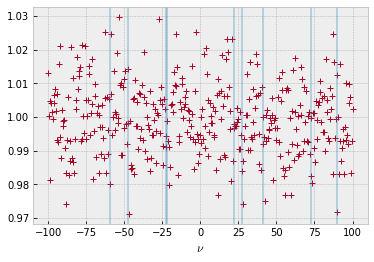

In [16]:
# Here is a mock dataset
plt.plot(nuarr,data,"+",color="C1")
for hatnu in hatnufix:
    plt.axvline(hatnu+nu0fix,alpha=0.3)
plt.xlabel("$\\nu$")
plt.show()

In [17]:
#probabilistic model using numpyro
def model(nu,y):
    A = numpyro.sample('A', dist.Uniform(0.0,1.0))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    mu = lpf.MultiAbsVTc(nu-nu0,sD,gL,A,Sfix,hatnufix)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [18]:
# OK, a HMC-NUTS!
# Our model, lpf.MultiAbsVTc, is compatible to jax. Autograd works. We can perform a HMC-NUTS.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:59<00:00, 50.23it/s, 7 steps of size 2.90e-01. acc. prob=0.86]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.04      0.01      0.04      0.02      0.05    938.69      1.00
        gL      0.29      0.21      0.26      0.00      0.53   1005.28      1.00
       nu0      1.54      0.49      1.55      0.82      2.26    789.63      1.00
        sD      0.93      0.40      0.88      0.33      1.49    888.49      1.00
     sigma      0.01      0.00      0.01      0.01      0.01    860.71      1.00

Number of divergences: 7


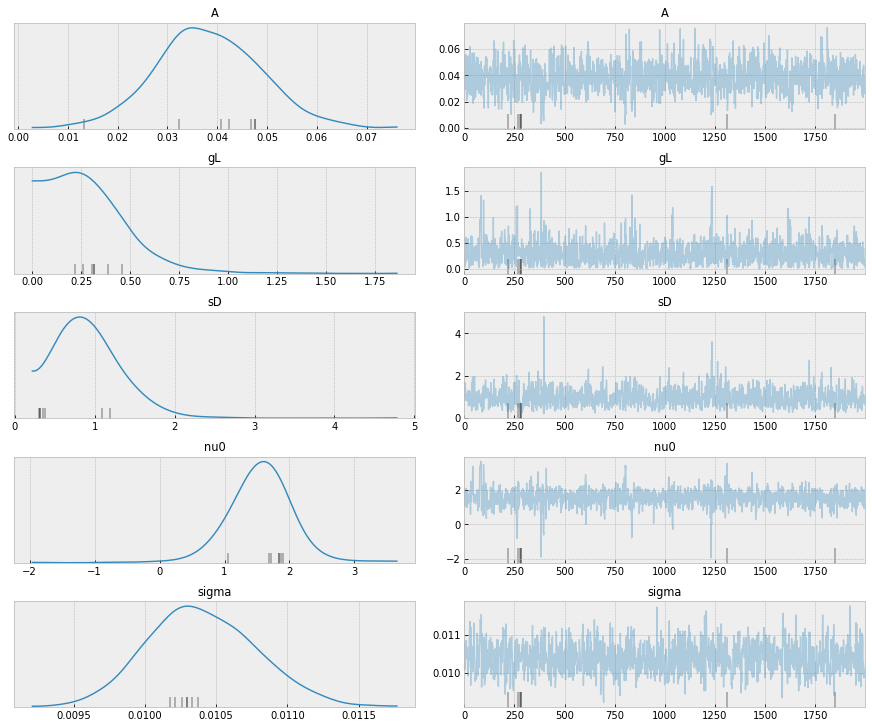

In [19]:
#arviz is superuseful to check chains
arviz.plot_trace(mcmc, var_names=["A", "gL", "sD","nu0","sigma"])
plt.show()

/home/kawahara/anaconda3/lib/python3.7/site-packages/arviz/plots/plot_utils.py:893: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


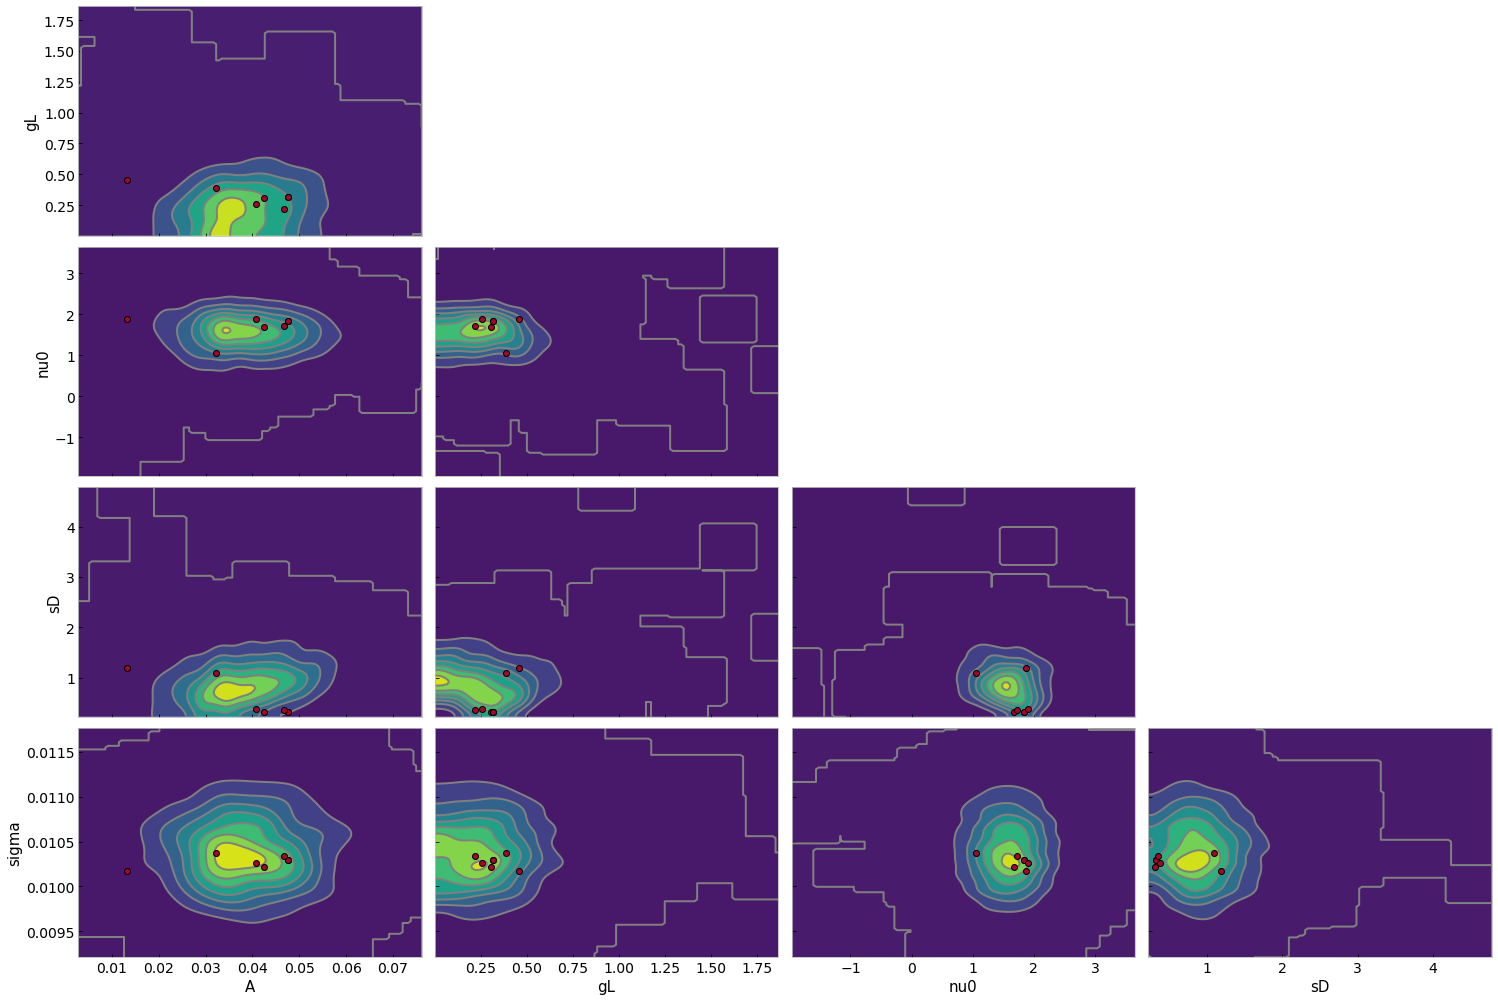

In [20]:
#cool and flexible corner plot in arviz. You can also try kind='hexbin' instead of 'kde' for instance.
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=True)
plt.show()

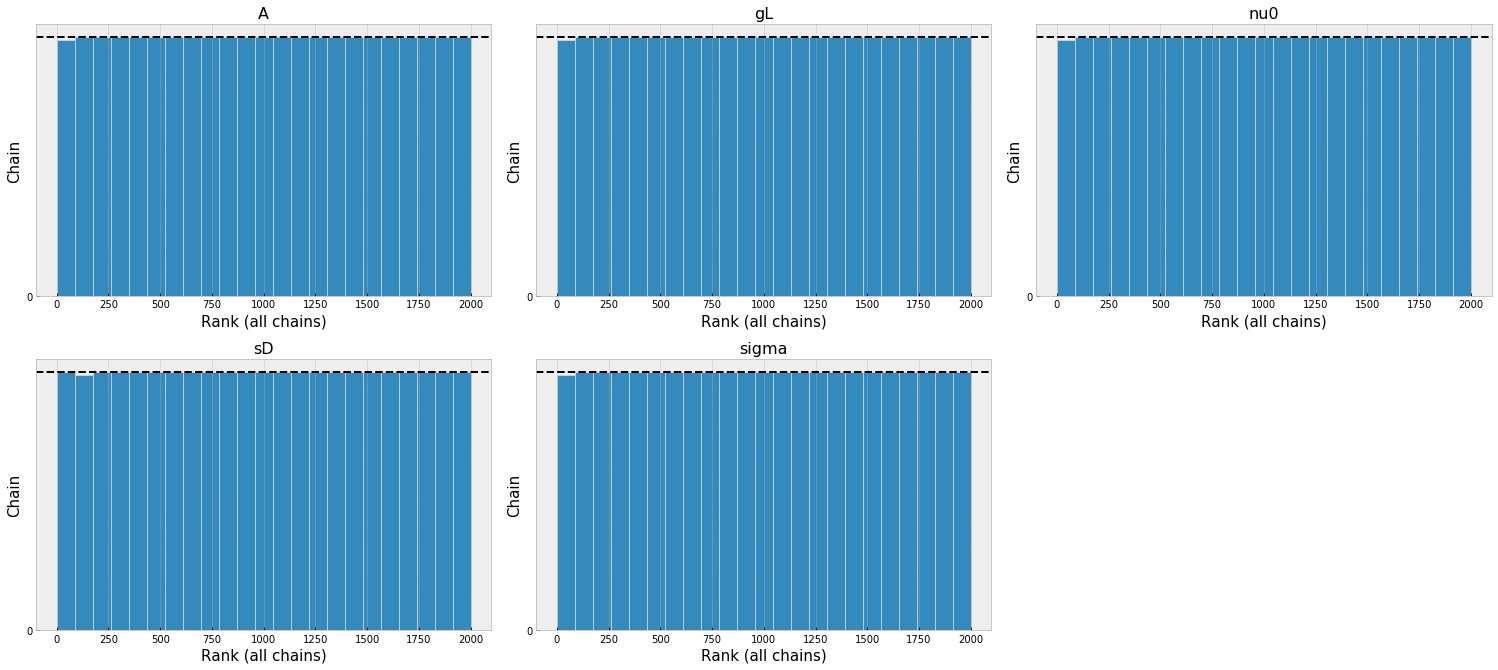

In [21]:
# further check of chain
arviz.plot_rank(arviz.from_numpyro(mcmc))
plt.show()

In [22]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = jnp.linspace(-100,100,1000)
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

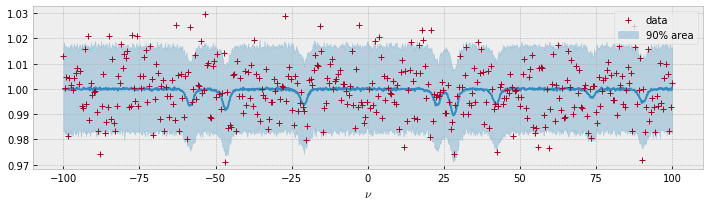

In [23]:
# final plot of median and 90% incredibl area of the prediction

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_multi_absorption.png")
plt.show()